In [1]:
import re
import pandas as pd
import numpy as np
from datetime import datetime

#pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-whitegrid')

import requests

import geocoder
import gmplot

In [2]:
# load csv file with all ambulance calls from 2013 - 2017

all_calls_df = pd.read_csv('.././Data/20170523_ambulancecalls_2013-2017.csv')

In [3]:
len(all_calls_df)

617088

### Current ambulance stands

In [15]:
stands_df = pd.read_csv('.././Data/Address_ambulancestands.csv')
stands_df['latlng'] = stands_df['address1'].map(lambda x: geocoder.google(x + ', Amsterdam').latlng)
stands_df.to_pickle('.././Data/ambulancestands_geo.p')
stands_df

,address1,address2,name_stand,latlng
0,Karperweg 19-25,1075 LB Amsterdam,"Ambulance Amsterdam, hoofdvestiging","[52.34827800000001, 4.8559545]"
1,Camperstraat t/o 56,1091 AJ Amsterdam,"Ambulance Amsterdam, Oost","[52.3576002, 4.913562499999999]"
2,Jan Tooropstraat 170,1061 AE Amsterdam,"Ambulance Amsterdam, West","[52.371439, 4.8381551]"
3,Statenjachtstraat 1C,1034 CS Amsterdam,"Ambulance Amsterdam, Noord","[52.4044603, 4.9222167]"
4,Meibergdreef 9,1105 AZ Amsterdam Z.O.,"Ambulance Amsterdam, Zuid-Oost","[52.29578069999999, 4.9563237]"
5,Spinnerij 15,1185 ZN Amstelveen,"Ambulance Amsterdam, Amstelveen","[52.28399109999999, 4.837243]"
6,Zwarteweg 77A,1431 VJ Aalsmeer,"Ambulance Amsterdam, Aalsmeer","[52.259256, 4.7644626]"


In [60]:
latitudes = stands_df['latlng'].map(lambda x: x[0])
longitudes = stands_df['latlng'].map(lambda x: x[1])

In [61]:
gmap = gmplot.GoogleMapPlotter(52.3469157,4.8639372,11)
gmap.scatter(latitudes, longitudes, 'black', size=300, marker=False)
gmap.draw("Amsterdam_stands_map.html")

In [ ]:
from IPython.display import IFrame
IFrame('Amsterdam_stands_map.html', width=600, height=600)

### Cleaning

In [4]:
# clean
all_calls_df.drop_duplicates(inplace=True)
all_calls_df.dropna(inplace=True)

# combine date and time column
all_calls_df['date_time'] = pd.to_datetime(all_calls_df['date'] + ' ' + all_calls_df['time'], format='%d-%m-%Y %H:%M:%S')
all_calls_df['date'] = pd.to_datetime(all_calls_df['date'], format='%d-%m-%Y')
all_calls_df['time'] = pd.to_datetime(all_calls_df['time'], format='%H:%M:%S')
all_calls_df.set_index('date_time', inplace=True)

# add urgency column
all_calls_df['urgency'] = all_calls_df['descr'].apply(lambda x: str(x).split(':')[0])

# only A1,A2,B1,B2,B calls
urgency_types  = [' Ambulance met hoge spoed',' Ambulance met spoed',
                  ' Ambulance besteld vervoer B1',' Ambulance besteld vervoer B2', 
                  ' Ambulance besteld vervoer']
select_calls_df = all_calls_df[all_calls_df['urgency'].isin(urgency_types)]

#select_calls_df.to_csv('20170616_ambulancecalls_2013-2017_cleaned.csv', index=True)

select_calls_df.head()

,date,time,address,descr,urgency
date_time,,,,,
2017-05-15 18:50:25,2017-05-15,1900-01-01 18:50:25,"Amstelveen, Frans Halslaan 10-18, 1181TL",Ambulance besteld vervoer B1: 13178 Rit 56159...,Ambulance besteld vervoer B1
2017-05-15 18:49:48,2017-05-15,1900-01-01 18:49:48,"Amsterdam, Van Hogendorpplein 20-28, 1051AX",Ambulance met hoge spoed: 13102 Rit 56158 Ams...,Ambulance met hoge spoed
2017-05-15 18:40:16,2017-05-15,1900-01-01 18:40:16,"Amsterdam, De Boelelaan , 1081HV",Ambulance besteld vervoer B1: 13405 Rit 56157...,Ambulance besteld vervoer B1
2017-05-15 18:37:55,2017-05-15,1900-01-01 18:37:55,"Amsterdam, Marnixstraat 1-9, 1017PJ",Ambulance met hoge spoed: 13116 Rit 56156 Ams...,Ambulance met hoge spoed
2017-05-15 18:31:50,2017-05-15,1900-01-01 18:31:50,"Amsterdam, Walmolen 100-108, 1035BP",Ambulance met hoge spoed: 13159 Rit 56155 Ams...,Ambulance met hoge spoed


In [5]:
del all_calls_df

### Data exploration

In [5]:
def plot_numbercalls(df, time_bin):
    """ Returns a plot with the number of ambulance calls per urgency type and time bin specified.
    Parameters:
        df: pandas df with datetime index
        time_bin: str
            Used for resampling, eg. 'D'/'W'/'M'
    """
    fig = plt.figure(figsize=(12,5))
    for urge in urgency_types:
        df2 = df[df['urgency']==urge]['urgency']
        ax = fig.add_subplot(1, 1, 1)
        df2.resample(time_bin).count().plot(ax=ax, label=urge)
    ax.legend(loc='best')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of calls per ' + time_bin )
    ax.set_title('Number of ambulance calls')
    plt.tight_layout()
    plt.show()
    

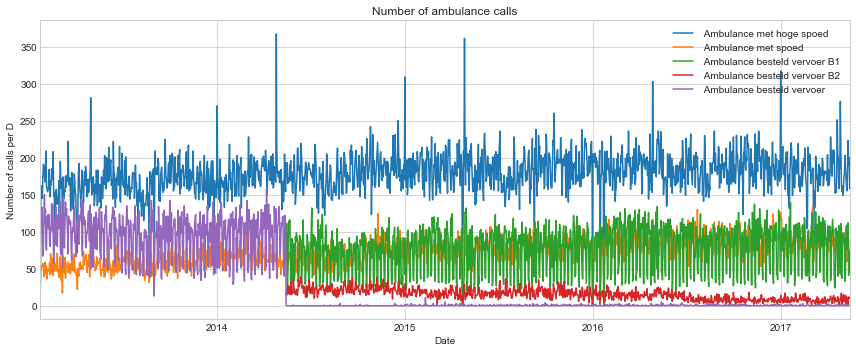

In [6]:
plot_numbercalls(select_calls_df, 'D')

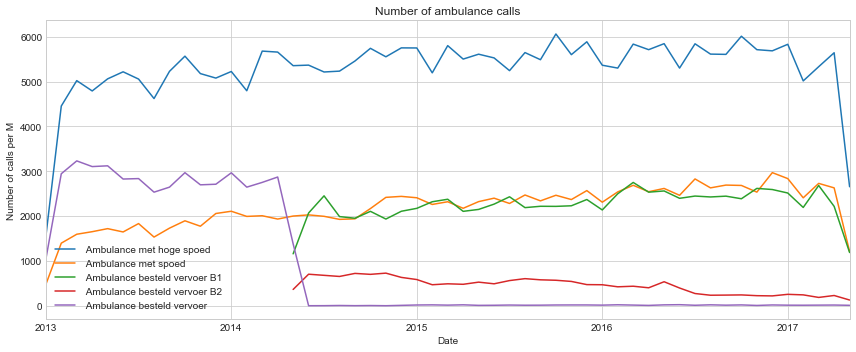

In [36]:
plot_numbercalls(select_calls_df, 'M')

Ambulance calls with high urgency have stayed stable over the last 3 years. 

#### Counts per day of the week

Looking at the number of calls per day shows a peak at kings day (2017 & 2016) and new years eve in 2017. However, the data is missing for new years day of 2016.

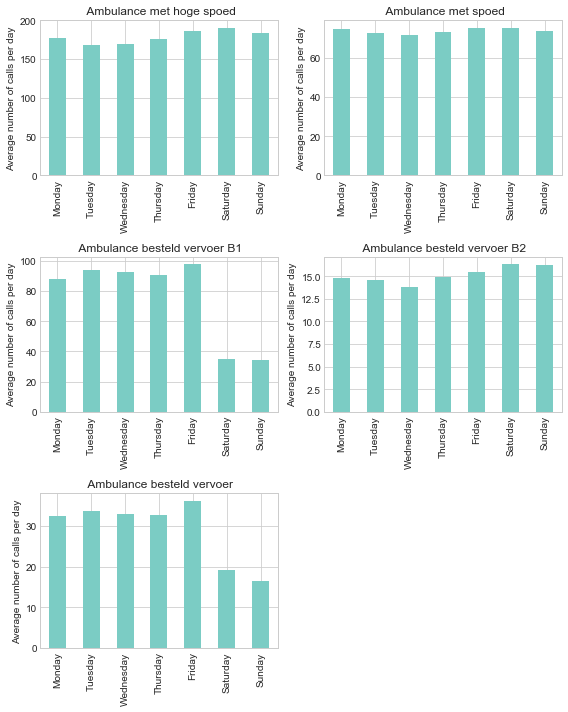

In [54]:
labels=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']

fig = plt.figure(figsize=(8,10))

count=1
for urge in urgency_types:
    df = select_calls_df[select_calls_df['urgency']==urge]['urgency']
    date_list = pd.date_range(df.index[len(df)-1].date(), df.index[0].date())
    count_days = date_list.dayofweek.value_counts().sort_index()
    count_calls = df.groupby(df.index.dayofweek).count()
    average_count = count_calls/count_days
    ax = fig.add_subplot(3, 2, count)
    average_count.plot(kind='bar', ax=ax, color='#7bccc4', label=urge)
    ax.set_xticklabels(labels)
    ax.set_ylabel('Average number of calls per day')
    ax.set_xlabel('')
    ax.set_title(urge)
    count+=1

plt.tight_layout()
#plt.savefig('NumberOfCalls_DayOfWeek.png', dpi=300)

Most ambulance calls take place on Friday

### Time series (TS) analysis

There's maybe a slight increase in very urgent ambulance calls over time (compare 2013 with 2016)  
Assumptions of TS modeling: mean, variance and covariance should not be a function of time ->   
We can check stationarity using **Dickey-Fuller test** (null-hypothesis = timeseries NOT stationary):  

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, windowsize):
    
    #Determing rolling statistics
    #Windowsize = number of observations used
    rolmean = pd.Series.rolling(timeseries, window=windowsize).mean()
    rolstd = pd.Series.rolling(timeseries, window=windowsize).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='steelblue',label='Original')
    mean = plt.plot(rolmean, color='firebrick', label='Rolling Mean')
    std = plt.plot(rolstd, color='dimgrey', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.ylabel('Number of calls')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    print('Window size = {} \n'.format(windowsize))
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:2], index=['Test Statistic','p-value'])
    print(dfoutput)

/usr/local/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


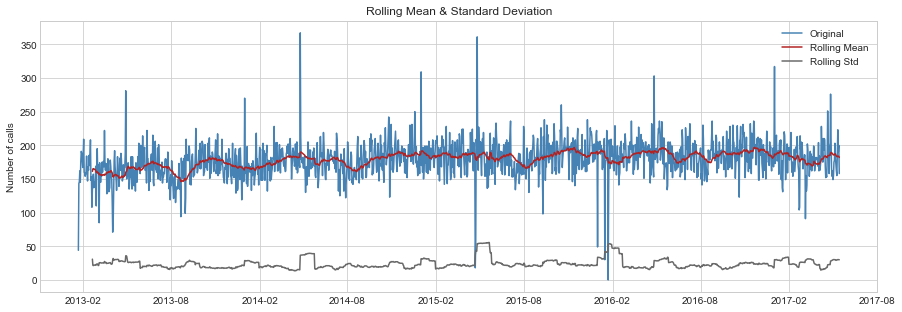

Window size = 30 

Results of Dickey-Fuller Test:
Test Statistic   -4.668171
p-value           0.000097
dtype: float64


In [8]:
ts = select_calls_df[select_calls_df['urgency']==' Ambulance met hoge spoed']['urgency']

ts_day = ts.resample('D').count()
test_stationarity(ts_day, 30)

In [37]:
len(ts)

281576

Dickey-Fuller test is significant, therefore the timeseries can be considered stationary over time and can be used for timeseries modeling.  

#### Another way to check stationary: seasonal decomposition

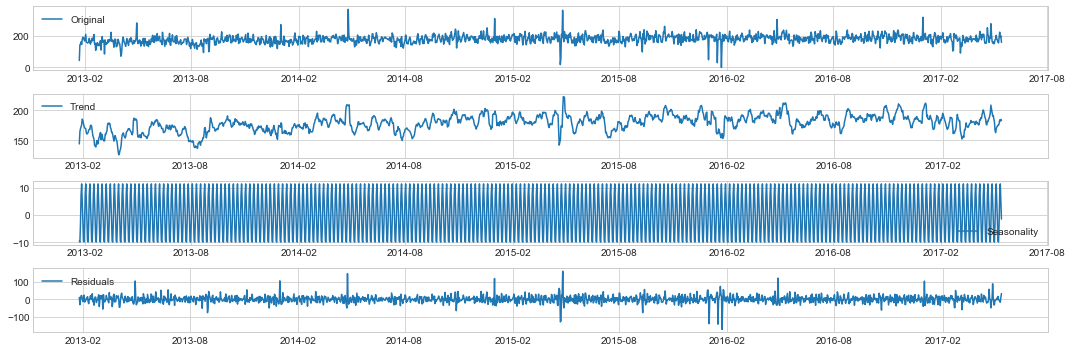

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_day)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(15,5))

plt.subplot(411)
plt.plot(ts_day, label='Original')
#plt.xlim(['Aug-2014','Dec-2014'])
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
#plt.xlim(['Aug-2014','Dec-2014'])
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
#plt.xlim(['Aug-2014','Dec-2014'])
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
#plt.xlim(['Aug-2014','Dec-2014'])
plt.legend(loc='best')
plt.tight_layout()


Seasonal decomposition also doesn't show a clear trend.  
Strange seasonality (variations specific to a particular time frame).  
Residual can be used as input to TS analysis, but the question is whether trend and seasonality are properly removed here.  

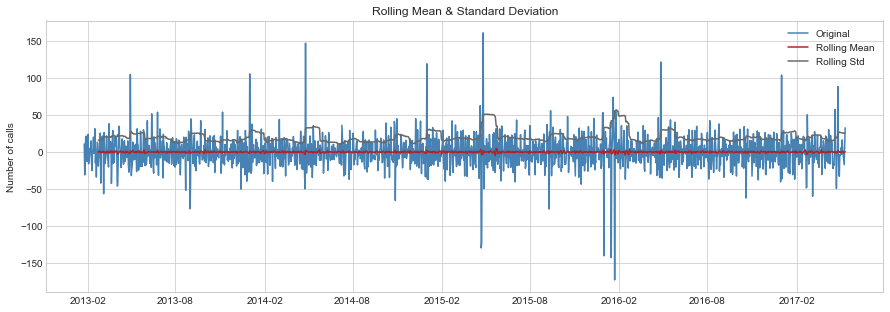

Window size = 30 

Results of Dickey-Fuller Test:
Test Statistic   -1.582181e+01
p-value           1.018070e-28
dtype: float64


In [10]:
ts_day_decompose = residual
ts_day_decompose.dropna(inplace=True)
test_stationarity(ts_day_decompose, 30)

#### ARIMA model
Auto-Regressive Integrated Moving Averages

First check autocorrelation to determine parameters of ARIMA.  

Autocorrelation Function (ACF): It is a measure of the correlation between the TS with a lagged version of itself.  
Partial Autocorrelation Function (PACF): This measures the correlation between the TS with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. 

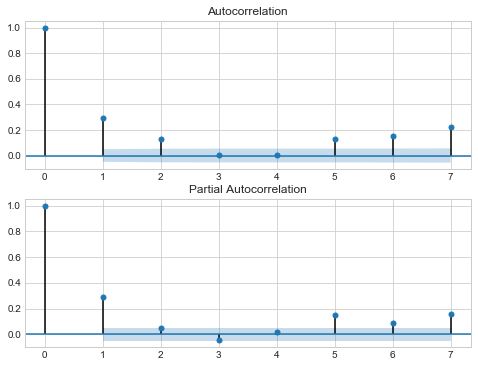

In [11]:
# Plot ACF and PACF

import statsmodels.graphics.tsaplots as tsaplt

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(211)
fig = tsaplt.plot_acf(ts_day, lags=7, ax=ax1)
ax2 = fig.add_subplot(212)
fig = tsaplt.plot_pacf(ts_day, lags=7, ax=ax2)

Autocorrelation below variance @3 -> q = 3  
Partial autocorrelation below variance @2 -> p = 2

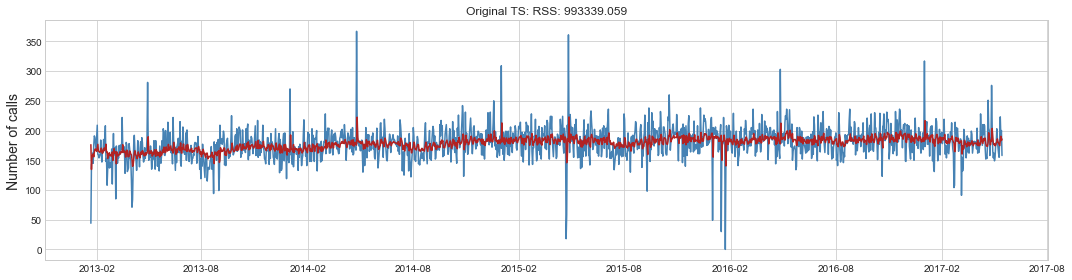

In [12]:
# TS Model

from statsmodels.tsa.arima_model import ARIMA

# ARIMA requires float data instead of integer
# Number of AR (Auto-Regressive) terms (p)
# Number of MA (Moving Average) terms (q)
# Number of Differences (d)

ts_day = ts_day.astype(float)

model = ARIMA(ts_day, order=(2, 0, 1))  # order from acf and pacf plots (p,d,q), but 2,0,1 has best fit
results_ARIMA = model.fit(disp=-1)  

plt.figure(figsize=(15,4))
plt.plot(ts_day, color='steelblue')
plt.plot(results_ARIMA.fittedvalues, color='firebrick')
plt.title('Original TS: RSS: %.3f'% sum((results_ARIMA.fittedvalues-ts_day)**2))
plt.ylabel('Number of calls', size=14)
plt.tight_layout()
plt.savefig('ARIMA_day.png', dpi=300)

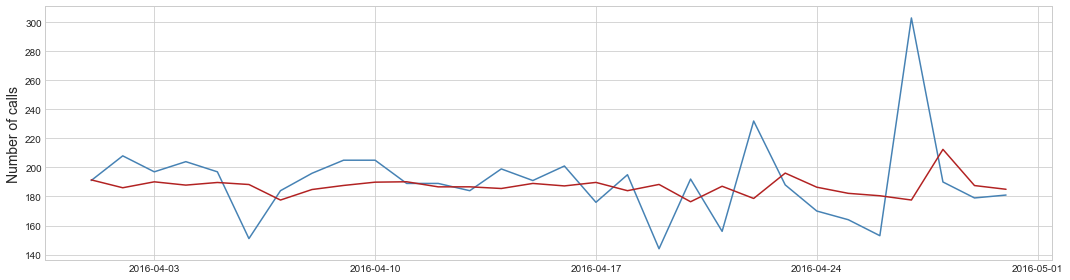

In [16]:
plt.figure(figsize=(15,4))
plt.plot(ts_day['2016-04'], color='steelblue')
plt.plot(results_ARIMA.fittedvalues['2016-04'], color='firebrick')
#plt.title('Original TS: RSS: %.3f'% sum((results_ARIMA.fittedvalues-ts_day)**2))
plt.ylabel('Number of calls', size=14)
plt.tight_layout()
plt.savefig('ARIMA_day_April.png', dpi=300)

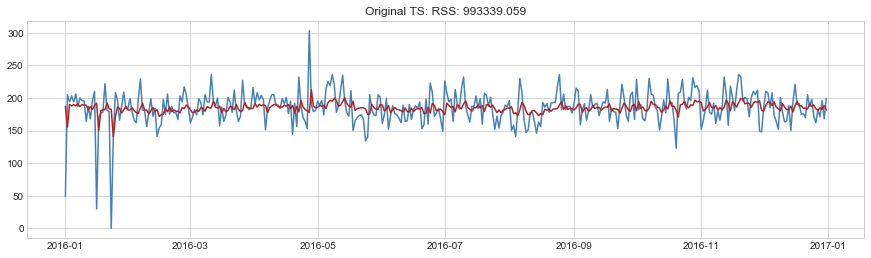

In [13]:
plt.figure(figsize=(15,4))
plt.plot(ts_day['2016'], color='steelblue')
plt.plot(results_ARIMA.fittedvalues['2016'], color='firebrick')
plt.title('Original TS: RSS: %.3f'% sum((results_ARIMA.fittedvalues-ts_day)**2))

ARIMA model fits very poorly on data

### Regressors

#### Add features to df
- kingsday / new years day 
- day of the week 
- day
- month
- hour


In [16]:
A1_df = select_calls_df[select_calls_df['urgency']==' Ambulance met hoge spoed']

A1_perday_df = A1_df['urgency'].resample('D').count().to_frame()
A1_perday_df.rename(columns={'urgency':'daily_count'}, inplace=True)

A1_perday_df['month'] = A1_perday_df.index.month
A1_perday_df['day'] = A1_perday_df.index.day
A1_perday_df['dayofweek'] = A1_perday_df.index.dayofweek

kingsdays = [datetime(2013,4,30), datetime(2014,4,26), datetime(2015,4,27), datetime(2016,4,27), datetime(2017,4,27)]
A1_perday_df['kingsday'] = [1 if x in kingsdays else 0 for x in A1_perday_df.index]

newyearsdays = [datetime(2014,1,1), datetime(2015,1,1), datetime(2016,1,1), datetime(2017,1,1)]
A1_perday_df['newyears'] = [1 if x in newyearsdays else 0 for x in A1_perday_df.index]

A1_perday_df.head()

,daily_count,month,day,dayofweek,kingsday,newyears
date_time,,,,,,
2013-01-22,44,1,22,1,0,0
2013-01-23,143,1,23,2,0,0
2013-01-24,146,1,24,3,0,0
2013-01-25,162,1,25,4,0,0
2013-01-26,145,1,26,5,0,0


In [31]:
def plot_regressor(regressor, yvalue):
    plt.figure(figsize=(18,5))
    plt.plot(test_df[yvalue], color='k', label='actual')
    plt.plot(test_df['prediction'], color='r', label='prediction (R$^2$ = {0:.3f})'.format(regressor.score(X_test, y_test)))
    plt.ylabel('Number of calls', size=14)
    plt.legend(loc='best', fontsize=14)
    plt.tight_layout()
    plt.savefig('figure.png', dpi=300)
    plt.show()

In [18]:
train_df = A1_perday_df[:'2016']
test_df = A1_perday_df['2017':]

X_train = train_df.drop('daily_count', axis=1)
y_train = train_df['daily_count']

X_test = test_df.drop('daily_count', axis=1)
y_test = test_df['daily_count']

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


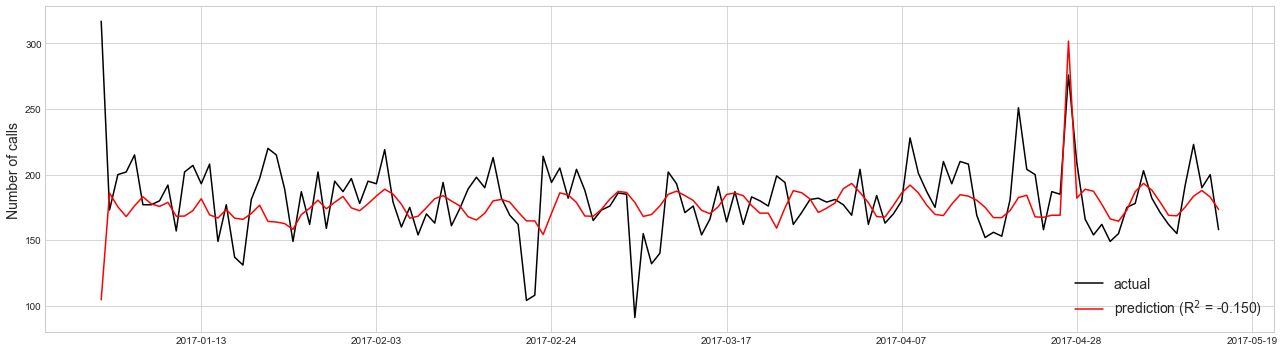

In [32]:
gbr = GradientBoostingRegressor(random_state=5)
gbr.fit(X_train, y_train)
test_df['prediction'] = gbr.predict(X_test)

plot_regressor(gbr, 'daily_count')

In [ ]:
from sklearn.ensemble import ExtraTreesRegressor

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


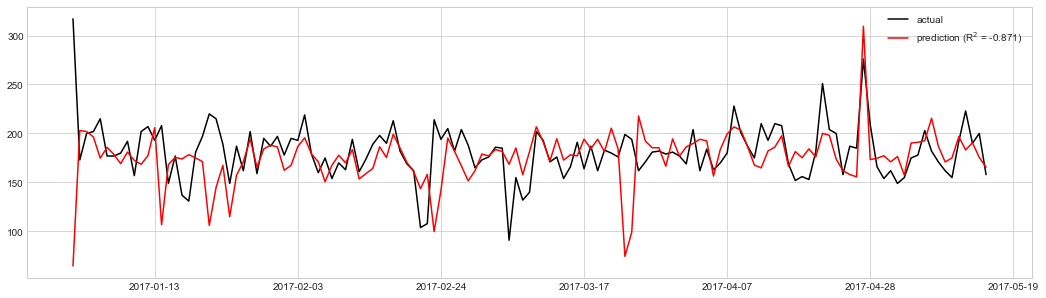

In [83]:
et = ExtraTreesRegressor()
et.fit(X_train, y_train)
test_df['prediction'] = et.predict(X_test)

plot_regressor(et, 'daily_count')

Conclusion: prediction with time features only is not sufficient